### Automating protest categories (MSA 2020) 🧍
Using machine learning to predict protester demands based on protest descriptions. 

<p> In light of recent civil unrest, including #blacklivesmatter and #metoo movements,it has never been more important for people in positions of power to listen voices.

<p> For my microsoft student accelerator project, I will be trying to develop machine learning model which can read descriptions about government protests, and construct a suitable label for the event.

<p> Along with certain RSS scraping methods, I would like to extend this project to automatically label incoming news articles in accordance to protest demands. I would also love to have more comprehesive labels to describe each event, to provide insightful analysis of what specifically demands are around the world, to see if there are any similarities and differences. 

### 👐🏼 Additional Resources I used to generate this resource:   

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

https://github.com/Currie32/Movie-Reviews-Sentiment/blob/master/RNN_movie_reviews.py

https://github.com/susanli2016/NLP-with-Python/blob/master/Multi-Class%20Text%20Classification%20LSTM%20Consumer%20complaints.ipynb

https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17


### 📦 Packages required

In [5]:
#import used packages
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import keras_metrics
from keras.regularizers import l2
from nltk.corpus import stopwords



### The Dataset ✊🏼

I will be using a dataset collected by the Mass Mobilisation data project. The dataset consists of protest events with over 50 or more protesters,  that cover 162 countries between 1990 and 2018. Each event has been extensively characterised based on country, date, protester demands and state responses. Information about these events has mostly been taken from news source. Each event also consists of a 200 word short description of the event that took place. The focus of this project will be based on trying to automatically label these descriptions based on protester demands. 

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HTTWYL

The protest demands were categorised into 8 categories, as inspected in the following code. 

* political behavior, process
* land farm issue'police brutality
* labor wage dispute
* price increases, tax policy
* social restrictions 
* removal of politicans
* other or ''

In [17]:
#move strata dataset from the project into a pandas dataframes
og_dataset = pd.read_stata("mmALL_020619_v15.dta")


#show all columns in dataset 
print("All columns within the dataset")
print(og_dataset.columns.values)

#shows all unique values in the protesterdemand column of the main dataset
print("Unique protester demands: ")
print(og_dataset.protesterdemand1.unique())



/Users/michellewong/opt/anaconda3/lib/python3.7/site-packages/pandas/io/stata.py:1409: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


All columns within the dataset
['id' 'country' 'ccode' 'year' 'region' 'protest' 'protestnumber'
 'startday' 'startmonth' 'startyear' 'endday' 'endmonth' 'endyear'
 'protesterviolence' 'location' 'participants_category' 'participants'
 'protesteridentity' 'protesterdemand1' 'protesterdemand2'
 'protesterdemand3' 'protesterdemand4' 'stateresponse1' 'stateresponse2'
 'stateresponse3' 'stateresponse4' 'stateresponse5' 'stateresponse6'
 'stateresponse7' 'sources' 'notes']
Unique protester demands: 
['political behavior, process' 'land farm issue' 'police brutality'
 'labor wage dispute' 'price increases, tax policy' ''
 'social restrictions' 'removal of politician']


Even though there are more than one protester demand catergory for some events, after an intial inspection, out of the 15,000 events in the data set at bit more than 2000 had more than one protester demand. Therefore I omitted them from the dataset. I also simplified the dataframe so that it only had to columns, the protester demand label and the description or notes in the dataset, to get the data ready for data processing. 

In [7]:
#rm samples from dataset which has more than one protester demand 
og_dataset = og_dataset[og_dataset.protesterdemand2 == ""]
#rm all columns except protesters and the description of the mass mobilisation event 
simp_dataset = og_dataset.loc[:, og_dataset.columns.intersection(['protesterdemand1','notes'])]
print("Columns left")
simp_dataset.head()

Columns left


,protesterdemand1,notes
1,"political behavior, process",protestors were only identified as young peop...
2,"political behavior, process","THE Queen, after calling on Canadians to rema..."
3,land farm issue,Canada s federal government has agreed to acq...
4,"political behavior, process",Protests were directed against the state due t...
5,police brutality,Canadian army troops today fired tear gas int...


### Data processing 🎬

I changed all capitalised words into non-capitalised words. This was done with the following function. 

In [10]:
# non-capitalise words 

simp_dataset.notes = simp_dataset.notes.reset_index(drop=True)

def clean_text(text):
    if type(text) == float:
        return text
    text = text.lower()
    return text

simp_dataset.notes = simp_dataset.notes.apply(clean_text)

I then wanted to split my data into test, validation and training sets.  I decided to reserve 12000 samples for training, 1180 for testing.

In [11]:
og_dataset = og_dataset[og_dataset.protesterdemand2 == ""]
simp_dataset = og_dataset.loc[:, og_dataset.columns.intersection(['protesterdemand1','notes'])]
simp_dataset.head()
non_test = simp_dataset.iloc[ :12000,:]
test = simp_dataset.iloc[12000:,:]
print(non_test.shape)
print(test.shape)

(12000, 2)
(1180, 2)


 After that, I tokenised and paded each protest description using keras's tokeniser and padding functions. 

In [12]:
"""Took training data and tokenised each protest description 
   with Kera's tokeniser tool """
train_clean = [review for review in non_test.notes]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_clean)
train_seq = tokenizer.texts_to_sequences(train_clean)
word_index = tokenizer.word_index
print(train_seq[1])



[1, 1940, 33, 219, 7, 7971, 3, 1370, 415, 2744, 27, 5, 1284, 416, 1205, 4574, 45, 3, 845, 3445, 2463, 8, 88, 2169, 702, 6, 672, 449, 608, 57, 12601, 34, 989, 354, 44, 3, 663, 1, 1940, 12602, 166, 6, 500, 4, 12603, 4574, 10, 693, 29, 424, 2464, 11, 8961, 12604, 1, 990, 193, 96, 5, 1877, 2964, 1254, 9, 35, 239, 1116, 12601, 2745, 1, 958, 62, 91, 2, 1, 16960, 4357, 2307, 13, 113, 30, 7972, 1, 505, 16, 6, 7211, 797, 162, 6, 229, 15, 99, 1, 2170, 1, 1940, 8, 3041, 156, 2, 6, 1054, 2414, 1140, 2463, 64, 19, 428, 7973, 11, 35, 239, 112, 2, 1, 1478, 16961, 16962, 57, 2, 74, 6603, 4, 1, 16963, 437, 16964, 1070, 915, 26, 162, 6, 5103, 36, 4791, 61, 85, 1, 6125, 16965, 500, 4, 12603, 6, 51, 2, 2598, 31, 2015, 327, 157, 1, 5393, 1717, 22, 1, 50, 2, 5393]


In [13]:
"""find the length of views by inspecting the length of view at the
80th , 85th, 90th and 95th percentile"""
#create a new dataframe containing lengths of each protest description
lengths = pd.DataFrame(map(len,train_seq), columns=['counts'])
"""determine the length at the 80th, 85th, 90th and 95th percentile
to figure out the average length of each protest de"""
lengths.counts.describe()
print("The average length of each piece at different percentiles")
print(np.percentile(lengths.counts, 80))
print(np.percentile(lengths.counts, 85))
print(np.percentile(lengths.counts, 90))
print(np.percentile(lengths.counts, 95))
#based on the longest average review length, pad sequences. 
max_review_length = 202
train_pad = pad_sequences(train_seq, maxlen = max_review_length)

The average length of each piece at different percentiles
111.0
128.0
155.0
202.0


I then turned first protesterdemand labels into vectorised labels and split by non-test data into training and validation data.  

In [15]:
#turns protesterdemands labels from categorical labels to one dimensional vectors 
Y = pd.get_dummies(non_test['protesterdemand1']).values
print(Y)

#split non-test data into training and validation data. 
print('Shape of label tensor:', Y.shape)
x_train, x_valid, y_train, y_valid = train_test_split(train_pad,Y, test_size = 0.15, random_state = 2)
print(x_train.shape)
print(x_valid.shape)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
Shape of label tensor: (12000, 8)
(10200, 202)
(1800, 202)


### 🛠 Training my model 

I then started to train my model with the following parameters: 

In [16]:
#Sequential API allows us to build the model layer by layer 
model = Sequential()

#Limits the words to top 30000 words which is the every word used
#in protest descriptions. Because this is a student project
#prioritise certains words. The model has will take the vectorised
#protest descriptions and turn them into 100 length vectors in the
#input layer. 
model.add(Embedding(30000, 100, input_length=train_pad.shape[1]))

#This adds a dropout layer to prevent overfitting 
model.add(SpatialDropout1D(0.2))
#This layer adds a LSTM algorithm with 100 memory units.
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#This generates the dense output layer, which consists of 8 neurons,
#corresponding to each protest category, regularisers were added to
#present overfitting. 
model.add(Dense(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation='softmax'))       
#The model will be compiled using categorical crossentropy because there
#are 8 different categories instead of binary categories.
#The Adam optimiser was chosen because it was seen to have to best metrics
#Metrics to evaluate the model was choosen to be accuracy. 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#only 2 epochs were used because previous runs of the program showed 
#the model quickly overfitted with larger epoch runs. 
epochs = 2
#A batch size of 64 reviews was used to space weight updates. 
batch_size = 64

#This starts the training assembly. 
history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/Users/michellewong/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10200 samples, validate on 1800 samples
Epoch 1/2
  640/10200 [>.............................] - ETA: 2:10 - loss: 2.1149 - accuracy: 0.5781

KeyboardInterrupt: 

### Evaluation 📈

First I plotted the graphs to figure out how well my training went, using learning curves. One of these curves plots the loss and one plots the accuracy of the model, against the number of times the data was trained, otherwise known as epoch. From my intial graphs i found that the training and validation sets diverged the most significantly from each other after epoch 2. This did not change even after regularisation and drop out was added.  Therefore, I retrained the model with only 2 epochs. 

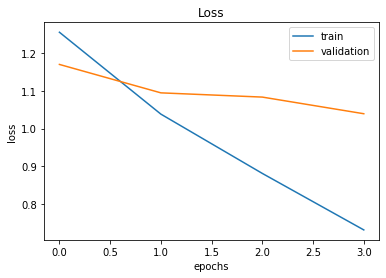

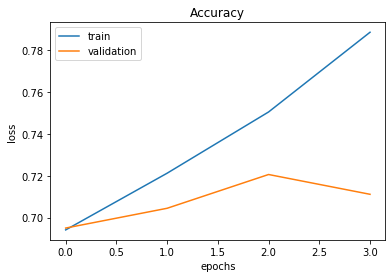

In [183]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show();

Previous results:

<img src="previousresults.png">

Next I prepared, tokenised and padded the test data. 

In [192]:
test_clean = []
for review in test.notes:
    test_clean.append(review)
    
tokenizer = Tokenizer()
tokenizer.fit_on_texts(test_clean)
test_seq = tokenizer.texts_to_sequences(test_clean)
word_index = tokenizer.word_index
lengths = []
for review in test_seq:
    lengths.append(len(review))
lengths = pd.DataFrame(lengths, columns=['counts'])
lengths.counts.describe()
max_review_length = 202
test_pad = pad_sequences(train_seq, maxlen = max_review_length)
Y = pd.get_dummies(non_test['protesterdemand1']).values

Next, I tested my data using a random test sample, to see if it could predict the correct label. For this example it correctly did so. 

In [187]:
index_of_label = []
labels = pd.get_dummies(og_dataset.protesterdemand1.unique()).values
for i in labels:
    index_of_label.append(np.argmax(i))

print(index_of_label)

test_number = 10
pred = model.predict(test_pad[[test_number]])
#test with specific examples 
labels = ['political behavior, process','land farm issue','police brutality',
 'labor wage dispute','price increases, tax policy','',
 'social restrictions','removal of politician']
print(np.argmax(pred))
print("predicted label: ",labels[index_of_label.index(int(np.argmax(pred)))])
print("actual label: ",test.iloc[test_number, 0])

[4, 2, 3, 1, 5, 0, 7, 6]
4
predicted label:  political behavior, process
actual label:  political behavior, process


I then tested my model's accuracy based on the entire test dataset.

In [188]:
#test based on whole dataset accuracy 

scores = model.evaluate(test_pad, Y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 78.79%


### 📕 Conclusion 

The model doesn't seem to be very accurate and tended to overfit the data after epoch 2, even when regularisation and drop out parameters has been implemented. This is likely because some of the protest data had very short descriptions and descriptions weren't very detailed. Perhaps a way to improve the model could be use the articles which the events were based, however some were too old to have the correct descriptions. 